In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import skinematics as skin
from IPython.display import clear_output
import time
from itertools import islice
import scipy.integrate as it
import pylab as pl
from IPython import display

In [122]:
data = pd.read_csv("./outputs/updated_data.csv")

In [123]:
velocity_x = it.cumtrapz(data["acc_x"],initial=0)
velocity_y = it.cumtrapz(data["acc_y"],initial=0)
velocity_z = it.cumtrapz(data["acc_z"],initial=0)

location_x = it.cumtrapz(velocity_x,initial=0)
location_y = it.cumtrapz(velocity_y,initial=0)
location_z = it.cumtrapz(velocity_z,initial=0)

location = np.array([location_x, location_y, location_z])

In [124]:
quat_data = data[["timestamp","quat_x","quat_y","quat_z","quat_w","label"]]

In [125]:
quat_data

,timestamp,quat_x,quat_y,quat_z,quat_w,label
0,1514824.503,0.321960,-0.596619,-0.621826,0.392090,0
1,1514827.496,0.321960,-0.596741,-0.621826,0.392029,0
2,1514830.493,0.321960,-0.596741,-0.621765,0.391968,0
3,1514833.500,0.321960,-0.596741,-0.621765,0.391968,0
4,1514836.498,0.321960,-0.596802,-0.621765,0.391907,0
...,...,...,...,...,...,...
14976,1618167.393,-0.312927,-0.112427,-0.932861,0.138855,4
14977,1618170.388,-0.312927,-0.112427,-0.932861,0.138855,4
14978,1618173.377,-0.264465,-0.108093,-0.946472,0.150146,4
14979,1618176.442,-0.218140,-0.103271,-0.956909,0.161560,4


In [126]:
'''
This module includes two functions:
    - An interactive viewer for time-series data ("view.ts")
    - An animation of 3D orientations, expressed as quaternions ("view.orientation")
    
For the time-series viewer, variable types that can in principle be plotted are:
    * np.ndarray
    * pd.core.frame.DataFrame
    * pd.core.series.Series

Viewer can be used to inspect a single variable, or to select one from the current workspace.

Notable aspects:
    - Based on Tkinter, to ensure that it runs on all Python installations.
    - Resizable window.
    - Keyboard-based interaction.
    - Logging of marked events.

'''

'''
ThH, Jan-2018
'''

import sys
import tkinter as tk
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from sys import _getframe
from os.path import expanduser, join

from mpl_toolkits.mplot3d import axes3d    
import matplotlib.animation as animation

# The following construct is required since I want to run the module as a script
# inside the skinematics-directory
import os
import sys

file_dir = os.path.dirname("Pison_Interview_Challenge")
if file_dir not in sys.path:
    sys.path.insert(0, file_dir)

import vector, quat
from sensors.xsens import XSens

# For Orientation_Viewers
import pygame
import OpenGL.GL as gl
import OpenGL.GLU as glu


# List if plottable datatypes
plottable = [np.ndarray, pd.core.frame.DataFrame, pd.core.series.Series]

class Orientation_OGL:
    """Orientation viewer utilizing OpenGL

    In the "zero" orientation, the pointer indicating the 3D orientation
    will point towards the lower right. In the display, the (x/y/z)-axes point
    in the (lower_right/lower_left/up) direction, respectively.

    Parameters
    ----------
    quat_in : (Nx3) or (Nx4) array
            Quaternion containing the orientation
    win_width : integer
            Pixel-width of the display window.
    win_height : integer
            Pixel-height of the display window.
    
    Examples
    --------
    >>> in_file = r'.\tests\data\data_xsens.txt'
    >>> from skinematics.sensors.xsens import XSens
    >>> data = XSens(in_file)
    >>> viewer = Orientation_OGL(quat_in=data.quat)
    >>> viewer.run(looping=False, rate=100)
    """
        
    def __init__(self, quat_in=None, rate=50, looping=False, win_width = 800, win_height = 600):
        '''Initialize the OpenGL-viewer'''
        
        # Camera
        self.cam_pos = [0.2, 0.2, 0]
        self.cam_target = [0, 0, -1]
        self.cam_up = [0, 1, 0]
        
        # OpenGL to my convention
        x = [1, 0, 0]
        y = [0, 0, -1]
        z = [0, 1, 0]
        self.openGL2skin = np.column_stack( (x,y,z) )
        
        # Initialize the pygame grafics setup
        pygame.init()
        self.display = (win_width, win_height)
        pygame.display.set_mode(self.display, pygame.DOUBLEBUF|pygame.OPENGL)

        self.define_elements()
        self.quat = quat_in
        

    def define_elements(self):
        '''Define the visual components'''
        
        # Define the pointer
        delta = 0.01
        self.vertices = (
            (0, -0.2, delta),
            (0, 0.2, delta),
            (0.6, 0, delta),
            (0, -0.2, -delta),
            (0, 0.2, -delta),
            (0.6, 0, -delta),
            )
        
        self.edges = (
            (0,1),
            (0,2),
            (0,3),
            (1,2),
            (1,4),
            (2,5),
            (3,4),
            (3,5),
            (4,5) )
        
        self.colors = (
            (0.8,0,0),
            (0.7,0.7,0.6),
            (1,1,1) )
        
        self.surfaces = (
            (0,1,2),
            (3,4,5),
            (0,1,3,4),
            (1,4,2,5),
            (0,3,2,5) )
        
        # Define the axes
        self.axes_endpts = np.array(
            [[-1,  0,  0],
             [ 1,  0,  0],
             [ 0, -1,  0],
             [ 0,  1,  0],
             [ 0,  0, -1],
             [ 0,  0,  1]])
        
        self.axes = (
            (0,1),
            (2,3),
            (4,5) )
        
    def draw_axes(self):
        '''Draw the axes. '''
        
        gl.glBegin(gl.GL_LINES)
        gl.glColor3fv(self.colors[2])
        
        # Here I have a difficulty with making the axes thicker
        #glLineWidth(1.5)
        
        for line in self.axes:
            for vertex in line:
                gl.glVertex3fv(self.axes_endpts[vertex])
                
        gl.glEnd()
    

    def draw_pointer(self, vertices):
        '''Draw the triangle that indicates 3D orientation.'''
        
        gl.glBegin(gl.GL_TRIANGLES)
    
        for (color, surface) in zip(self.colors[:2], self.surfaces[:2]):
            for vertex in surface:
                gl.glColor3fv(color)
                gl.glVertex3fv(vertices[vertex])
        gl.glEnd()
    
        gl.glBegin(gl.GL_LINES)
        gl.glColor3fv(self.colors[2])
        
        for edge in self.edges:
            for vertex in edge:
                gl.glVertex3fv(vertices[vertex])
        gl.glEnd()
        

    def run(self, rate=100, looping=True):
        '''Run the viewer
        
        Parameters
        ----------
        rate : integer
            Sample rate for the display [Hz]. Lower numbers result in slower display.
        looping : boolean
            If set to "True", the display will loop until the window is closed.
        '''
            
        dt = int(1/rate*1000)  # [msec]

        # Camera properties, e.g. focal length etc
        gl.glMatrixMode(gl.GL_PROJECTION)
        gl.glLoadIdentity()
        
        glu.gluPerspective(45, (self.display[0]/self.display[1]), 0.1, 50.0)
        gl.glTranslatef(0.0,0.0, -3)
    
        counter = 0
        while True:
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    quit()
                    
            counter = np.mod(counter+1, self.quat.shape[0])
            if not looping and counter == self.quat.shape[0]-1:
                break
            
            gl.glClear(gl.GL_COLOR_BUFFER_BIT|gl.GL_DEPTH_BUFFER_BIT)
            gl.glEnable(gl.GL_DEPTH_TEST)
    
            # Camera position
            gl.glMatrixMode(gl.GL_MODELVIEW) 
            gl.glLoadIdentity()
            glu.gluLookAt(
                self.cam_pos[0], self.cam_pos[1], self.cam_pos[2],
                self.cam_target[0], self.cam_target[1], self.cam_target[2], 
                self.cam_up[0], self.cam_up[1], self.cam_up[2] )
    
            # Scene elements
            gl.glPushMatrix()
            cur_corners = vector.rotate_vector(self.vertices, self.quat[counter]) @ self.openGL2skin.T
            #cur_corners = cur_corners * np.r_[1, 1, -1] # This seems to be required
                        ##to get things right - but I don't understand OpenGL at this point
            
            self.draw_pointer(cur_corners)
            gl.glPopMatrix()
            self.draw_axes()
            
            pygame.display.flip()
            pygame.time.wait(dt)
            
            
def orientation(quats, location, out_file=None, title_text=None, deltaT=100):
    '''Calculates the orienation of an arrow-patch used to visualize a quaternion.
    Uses "_update_func" for the display.
    
    Parameters
    ----------
    quats : array [(N,3) or (N,4)]
            Quaterions describing the orientation.
    out_file : string
            Path- and file-name of the animated out-file (".mp4"). [Default=None]
    title_text : string
            Name of title of animation [Default=None]
    deltaT : int
            interval between frames [msec]. Smaller numbers make faster
            animations.
    
    Example
    -------
        To visualize a rotation about the (vertical) z-axis:
        
    >>> # Set the parameters
    >>> omega = np.r_[0, 10, 10]     # [deg/s]
    >>> duration = 2
    >>> rate = 100
    >>> q0 = [1, 0, 0, 0]
    >>> out_file = 'demo_patch.mp4'
    >>> title_text = 'Rotation Demo'
    >>> 
    >>> # Calculate the orientation
    >>> num_rep = duration*rate
    >>> omegas = np.tile(omega, [num_rep, 1])
    >>> q = skin.quat.calc_quat(omegas, q0, rate, 'sf')
    >>>     
    >>> orientation(q, out_file, 'Well done!', deltaT=1000./rate)
            
    '''
    
    # Initialize the 3D-figure
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')

    # Define the arrow-shape and the top/bottom colors
    delta = 0.01    # "Thickness" of arrow
    corners = [[0, 0, 0.6],
             [0.2, -0.2, 0],
            #[location[0], location[1], location[2]]]
             [0, 0, 0]]
    colors = ['r', 'b']
    
    # Calculate the arrow corners
    corner_array = np.column_stack(corners)
    
    corner_arrays = []
    corner_arrays.append( corner_array + np.r_[0., 0., delta] )
    corner_arrays.append( corner_array - np.r_[0., 0., delta] )
    
    # Calculate the new orientations, given the quaternion orientation
    all_corners = []
    for quat in quats:
        all_corners.append([vector.rotate_vector(corner_arrays[0], quat), 
                            vector.rotate_vector(corner_arrays[1], quat)])
        
    # Animate the whole thing, using 'update_func'
    num_frames = len(quats)
    ani = animation.FuncAnimation(fig, _update_func, num_frames,
                                  fargs=[all_corners, colors, ax, title_text],
                                  interval=deltaT)
    
    # If requested, save the animation to a file
    if out_file is not None:
        try:
            ani.save(out_file)
            print('Animation saved to {0}'.format(out_file))
        except ValueError:
            print('Sorry, no animation saved!')
            print('You probably have to install "ffmpeg", and add it to your PATH.')
    
    plt.show()    
    
    return


def _update_func(num, all_corners, colors, ax, title=None):
    '''For 3D plots it seems to be impossible to only re-set the data values,
    so the plot has to be cleared and re-generated for each frame
    '''
    
    # Clear previous plot
    ax.clear()

    # Plot coordinate axes
    ax.plot([-1, 1], [0, 0], [0, 0])
    ax.plot([0, 0], [-1, 1], [0, 0])
    ax.plot([0, 0], [0, 0], [-1, 1])
    
    # Format the plot
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    #plt.zlim(-1000, 1000)
    plt.xlabel('x')
    plt.ylabel('y')
    
    try:
        # Plot and color the top- and bottom-arrow
        for up_down in range(2):
            corners = all_corners[num][up_down]
            ph = ax.plot_trisurf(corners[:,0], corners[:,1], corners[:,2])
            ph.set_color(colors[up_down])
        
        if title is not None:
            plt.title(title)
        
    except RuntimeError:
        # When the triangle is exactly edge-on "plot_trisurf" seems to have a numerical problem
        print('Cannot show triangle edge-on!')
    return

class Display:
    def __init__(self, master, data=None):
        '''Create all frames, buttons and labels'''
        
        if type(data) not in plottable:
            self.inDictionary = data
            data = None
            
        self.master = master
        
        if data is None:
            data = np.arange(1)
            
        if data.ndim == 1:
            data = np.atleast_2d(data).T
        self.numData = data.shape[1]
        
        # Generate the figure -------------------------------------------
        fig, self.axs = plt.subplots(nrows=self.numData, sharex=True, 
                                    sharey=False)
        
        if self.numData == 1:
            self.axs = [self.axs]
                
        self.lines = []
        self.rects = []
        self.zeros = []
        for ii in range(self.numData):
            self.lines.append(self.axs[ii].plot(data[:,ii]))
        
            # Zero line
            self.zeros.append(self.axs[ii].hlines(0,0,len(data), linestyle='dotted'))
        
            # Zoom box
            self.epsilon = 5
            (x0,x1,y0,y1) = (0,0,0,0)
            self.rects.append(Line2D([x0,x1,x1,x0,x0], [y0,y0,y1,y1,y0], linestyle='dotted'))
            self.axs[ii].add_line(self.rects[-1])
            
        # Create the canvas
        self.canvas = FigureCanvasTkAgg(fig,master=master)
        self.canvas.show()
        self.canvas.get_tk_widget().pack(side='top', fill='both', expand=1)
        
        # Keyboard and mouse control
        self.button = False
        self.marks = []
        self.canvas.mpl_connect('key_press_event', self.on_key_event)
        self.canvas.mpl_connect('button_press_event', self.onclick)        
        self.canvas.mpl_connect('button_release_event', self.onrelease)        
        self.canvas.mpl_connect('motion_notify_event', self.onmotion)        
        
        # Create and pack the widgets
        self.createWidgets()
        self.showAll()
        
        if 'inDictionary' in dir(self):
            self.selectPlotVar()
            
        
    def createWidgets(self):
        '''Create frames, buttons, text, etc.'''
        
        # Frame for the slider
        frame_0_top = tk.Frame(self.master)
        
        self.scale = tk.Scale(frame_0_top,
                                   from_=0, to=1, resolution=0.01,
                                   orient=tk.HORIZONTAL,
                                   length=500, sliderlength=50,
                                   showvalue=False,
                                   command=self.position)
        self.scale.set(0.0)
        self.scale.pack(fill=tk.X, ipadx=10)
        
        frame_0_bottom = tk.Frame(self.master)
        
        # Frame for Load/Exit buttons -----------------------
        frame_1 = tk.Frame(frame_0_bottom)
        # Create 2 buttons
        self.button_exit = tk.Button(frame_1,text="Exit",
                                           foreground='red',
                                        command=self.exit)
        self.button_exit.pack(side="right")
        self.button_load = tk.Button(frame_1,text="Load",
                                          fore='green',
                                        command=self.selectPlotVar)
        self.button_load.pack(side="right")
        self.button_showAll = tk.Button(frame_1,text="ShowAll",
                                        foreground='blue',
                                        command=self.showAll)
        self.button_showAll.pack(side="right")
        
        # Frame for navigation buttons ----------------------
        frame_2 = tk.Frame(frame_0_bottom)
        # Add navigation buttons
        self.button_ff = tk.Button(frame_2,text=">>",
                                        command=self.fforward)
        self.button_ff.pack(side="right")
        self.button_ff = tk.Button(frame_2,text=">",
                                        command=self.forward)
        self.button_ff.pack(side="right")
        self.button_ff = tk.Button(frame_2,text="<",
                                        command=self.backward)
        self.button_ff.pack(side="right")
        self.button_ff = tk.Button(frame_2,text="<<",
                                        command=self.fbackward)
        self.button_ff.pack(side="right")

        # Frame for entering text -----------------------------
        frame_3 = tk.Frame(frame_0_bottom)
        
        # Subframe for upper/lower limit
        frame_3_lim = tk.Frame(frame_3)
        
        # Subsubframe for upper limit
        frame_upper = tk.Frame(frame_3_lim)
        frame_lower = tk.Frame(frame_3_lim)
        
        label_upper = tk.Label(frame_upper, text="Upper Limit")
        label_upper.pack(side='left')
        label_lower = tk.Label(frame_lower, text="Lower Limit")
        label_lower.pack(side='left')
        
        self.text_upper = tk.Entry(frame_upper)
        self.text_upper.pack(side='right')
        self.text_lower = tk.Entry(frame_lower)
        self.text_lower.pack(side='right')
        
        # Subframe for rate
        frame_3_rate = tk.Frame(frame_3)
        
        label_rate = tk.Label(frame_3_rate, text='Rate')
        self.text_rate = tk.Entry(frame_3_rate)
        self.text_rate.insert(0, '1')
        
        # Checkbutton for loggin
        frame_3_log = tk.Frame(frame_3)
        
        label_log = tk.Label(frame_3_log, text='Log')
        self.chkVar = tk.IntVar()
        log_check = tk.Checkbutton(frame_3_log,
                                        variable=self.chkVar,
                                        command=self.log)
        
        # Pack the elements, and assign key bindings ---------------------
        frame_0_top.pack()
        frame_0_bottom.pack()
        frame_1.pack(side="right")
        frame_2.pack(side="right", expand=1)
        frame_3.pack(side="left", expand=1)
        
        frame_3_lim.pack(side="left", padx=5, expand=1)
        frame_upper.pack()
        frame_lower.pack()
        
        label_upper.pack(side='left')
        self.text_upper.bind('<Return>', self.setUpperLimit)
        self.text_upper.pack(side='left')

        label_lower.pack(side='left')
        self.text_lower.bind('<Return>', self.setLowerLimit)
        self.text_lower.pack(side='left')

        frame_3_rate.pack(side='left', padx=5, expand=1)
        label_rate.pack()
        self.text_rate.bind('<Return>', self.setRate)
        self.text_rate.pack()
        #self.text_rate.event_generate('<Return>')
        self.setRate('<Return>')
        
        frame_3_log.pack(side='left', padx=5, expand=1)
        label_log.pack()
        log_check.pack()
        
    def log(self):
        '''Log right mouse clicks'''
        
        #print('logging is {0}'.format(self.chkVar.get()))
        if self.chkVar.get() == 1 and 'logFile' not in dir(self):
            home = expanduser('~')
            self.logFile = join(home, 'default.log')
            print('right-Mouse clicks are logged into {0}'.format(self.logFile))
            
        
    def onmotion(self, event):
        '''Event for mouse dragging'''
        
        if self.button:
            self._stop = (event.x, event.y, event.xdata, event.ydata)
            x = [self._start[2], self._stop[2]]
            y = [self._start[3], self._stop[3]]
            
            for ii in range(self.numData):
                self.rects[ii].set_xdata([x[0],x[1],x[1],x[0],x[0]])
                self.rects[ii].set_ydata([y[0],y[0],y[1],y[1],y[0]])
            #print('button=%d, x=%d, y=%d, xdata=%f, ydata=%f'%(
                #event.button, event.x, event.y, event.xdata, event.ydata))
    
        self.canvas.draw()
        
    def onclick(self, event):
        '''Select the button-down position'''
        
        if event.button == 1:
            # left mouse click
            self._start = (event.x, event.y, event.xdata, event.ydata)
            self.button = True
        if event.button == 3:
            # right mouse click
            if self.chkVar.get() == 1:
                # right mouse click
                self.marks.append(event.xdata)
                for ii in range(self.numData):
                    self.axs[ii].vlines(event.xdata, self.range[2], self.range[3])
                
        self.canvas.draw()
    
    def onrelease(self, event):
        '''Select the button-up position, and zoom in on the selected range'''
        
        if self.button == True: # only for left mouse clicks
            self._stop = (event.x, event.y, event.xdata, event.ydata)
            self.button = False
            
            # Only zoom in if a "reasonably" large area has been selected
            curDist = dist(np.r_[self._start[:2]], np.r_[self._stop[:2]])
        
    def on_key_event(self, event):
        '''Keyboard interaction'''
        
        #print('you pressed %s'%event.key)        
        
        key = event.key
        
        # In Python 2.x, the key gets indicated as "alt+[key]"
        # Bypass this bug:
        if key.find('alt') == 0:
            key = key.split('+')[1]
        
        if key == 'f':
            self.forward()
        elif key == 'n':
            self.fforward()
        elif key == 'b':
            self.backward()
        elif key == 'p':
            self. fbackward()
        elif key == 'x':
            self.exit()
        elif key == 'a':
            self.showAll()
        elif key == 'z':
            self.zoom()
            
    def setRate(self, event):
        '''Set the rate. Also use this to initialize a number of default values, 
        and the values for the limit-boxes.'''
        
        rate = float(self.text_rate.get())
        minVal = 0
        maxVal = 0
        for line in self.lines:
            x,y = line[0].get_data()
            pnts = np.arange(len(x))
            time = pnts/rate
            line[0].set_xdata(time)
            minVal = min(minVal, np.min(y))
            maxVal = max(maxVal, np.max(y))
        
        # Initially, show all data
        for ii in range(self.numData):
            # to avoid some spurious UserWarning
            max_range = np.max(time)
            if max_range == 0.0:
                max_range += 0.001
            self.axs[ii].set_xlim([0, max_range])
        
        # Make sure small numbers are nicely formatted
        if max(np.abs([minVal, maxVal])) < 0.01:
            strMin = '{0:.2e}'.format(minVal)
            strMax = '{0:.2e}'.format(maxVal)
        else:
            strMin = '{0:.2f}'.format(minVal)
            strMax = '{0:.2f}'.format(maxVal)
            
        self.text_lower.delete(0, tk.END)
        self.text_lower.insert(0, strMin)
        
        self.text_upper.delete(0, tk.END)
        self.text_upper.insert(0, strMax)
        
        # Set limit and range parameters
        curLim = self.axs[0].get_xlim()
        xMin = 0
        xMax = np.max(time)
        self.xRange, = np.diff(curLim)
        self.sliderMax = xMax-self.xRange
        self.range = [xMin, xMax, minVal, maxVal]
        
        # Draw canvas
        self.canvas.draw()
        self.canvas._tkcanvas.focus_set()
        
    def zoom(self):
        ''' Show all the data on the y-axis, and 10% of all on the x-axis. '''
        
        for ii in range(self.numData):
            self.axs[ii].set_xlim([0, 0.1*self.range[1]])
            self.axs[ii].set_ylim(self.range[2:])
        self.xRange = 0.1*self.range[1]
        self.sliderMax = self.range[1]-self.xRange
        self.scale.set(0)
        self.canvas.draw()
        
    def showAll(self):
        ''' Show all the data '''
        
        for ii in range(self.numData):
            # The "if" is to avoid some spurious "UserWarning"
            if np.diff(self.range[:2])== 0.:
                self.axs[ii].set_xlim([-0.001, 0.001])
            else:
                self.axs[ii].set_xlim(self.range[:2])
                
            if np.diff(self.range[2:])== 0.:
                self.axs[ii].set_ylim([-0.001, 0.001])
            else:
                self.axs[ii].set_ylim(self.range[2:])
        self.xRange = self.range[1]
        self.scale.set(0)
        self.canvas.draw()
        
    def setUpperLimit(self, event):
        '''Set the "Upper Limit" '''
        
        UpperLimit = float(self.text_upper.get())
        self.text_lower.delete(0, tk.END)
        self.text_lower.insert(0, str(-UpperLimit))
        
        for ii in range(self.numData):
            self.axs[ii].set_ylim([-UpperLimit, UpperLimit])
        self.canvas.draw()
        self.canvas._tkcanvas.focus_set()
        
    def setLowerLimit(self, event):
        '''Set the "Lower Limit" '''
        
        UpperLimit = float(self.text_upper.get())
        LowerLimit = float(self.text_lower.get())
        
        for ii in range(self.numData):
            self.axs[ii].set_ylim([LowerLimit, UpperLimit])
        self.canvas.draw()
        self.canvas._tkcanvas.focus_set()
        
    def update_xPos(self, xLim):
        ''' Set the x-range, and check that the limits are within the possible range. ''' 
        
        xMin = self.range[0] 
        xMax = self.range[1]
        # Check the minimum position
        if xLim[0] < xMin:
            xLim = [xMin, xMin+self.xRange]
        
        # Check the maximum position
        if xLim[1] > xMax:
            xLim = [xMax-self.xRange, xMax]
        
        # Update xlimits, and redraw the screen
        if self.sliderMax == 0:
            self.scale.set(0)
        else:
            self.scale.set(float(xLim[0])/self.sliderMax)
            
        for ii in range(self.numData):
            self.axs[ii].set_xlim(xLim)
        self.canvas.draw()
        
    def position(self, event):
        '''Position window according to slider '''
        sliderPos = self.scale.get()
        newLim = np.r_[0, self.xRange] + sliderPos*self.sliderMax
        
        self.update_xPos(newLim)
        
    def forward(self):
        '''Move data forward by half the visible distance'''
        for ii in range(self.numData):
            curLim = self.axs[ii].get_xlim()
        newLim = curLim + self.xRange/2
        
        self.update_xPos(newLim)
        
    def fforward(self):
        '''Move data forward by one visible distance'''
        for ii in range(self.numData):
            curLim = self.axs[ii].get_xlim()
        newLim = curLim + self.xRange
        
        self.update_xPos(newLim)
    
    def backward(self):
        '''Move data backward by half the visible distance'''
        for ii in range(self.numData):
            curLim = self.axs[ii].get_xlim()
        newLim = curLim - self.xRange/2
        
        self.update_xPos(newLim)
    
    def fbackward(self):
        '''Move data back by one visible distance'''
        for ii in range(self.numData):
            curLim = self.axs[ii].get_xlim()
        newLim = curLim - self.xRange
        
        self.update_xPos(newLim)
    
    def exit(self):
        '''Close the window, and - if necessary - save
        the right-clicked marks.'''
        
        if self.chkVar.get() == 1:
            np.savetxt(self.logFile, self.marks)
            print('right-Mouse clicks are saved into {0}'.format(self.logFile))
            
        self.master.quit()  
        self.master.destroy()  # If you don't use both, Python crashes under Python 2.x
        
    def updatePlot(self):
        '''update the figure'''
        
        for ii in range(self.numData):
            for line in self.lines[ii]:
                # Remove the old lines
                line.remove()
            self.zeros[ii].remove()
            
            # plot the new data
            #self.axs[ii].set_color_cycle(None)
            self.lines[ii] = self.axs[ii].plot(self.varValues)
            self.zeros[ii] = self.axs[ii].hlines(0,0,len(self.varValues), linestyle='dotted')
        self.master.title(self.varName)
        self.range = [0, len(self.varValues), np.min(self.varValues), np.max(self.varValues)]
        self.showAll()
        
        self.text_upper.delete(0, tk.END)
        self.text_upper.insert(0, str(self.range[3]))
        self.text_lower.delete(0, tk.END)
        self.text_lower.insert(0, str(self.range[2]))
        
        
        self.canvas.draw()
        self.master.call('wm', 'attributes', '.', '-topmost', '1')
        
    def selectPlotVar(self):
        ''' Select a plottable variable from those in the workspace. '''
        
        if 'inDictionary' not in dir(self):
            print('No additional variables available!')
        else:
            # Create a new window
            self.loadWindow = tk.Toplevel(self.master)
            varSelector = VarSelector(self.loadWindow, self)
            varSelector.master.title('Selection')
        
class VarSelector():
    '''Class for the GUI-display of plottable items
    
        Analyze the current workspace for variables that can be plotted, and let the user select one.
        Variable types that can in principle be plotted are:

            - np.ndarray
            - pd.core.frame.DataFrame
            - pd.core.series.Series

        '''

    def __init__(self, selectionWindow,  mainApp):
        
        varList = mainApp.inDictionary.keys()
        plotList = []
        for curType in plottable:
            plotList += [var for var in varList if type(mainApp.inDictionary[var])==curType]
        
        self.master = selectionWindow
        self.frame = tk.Frame(selectionWindow)
        self.frame.grid()
        self.createWidgets(plotList)
        self.mainApp = mainApp
        
    def selectAndQuit(self):
        '''Grab the selected item, update the main plot, and close the VarSelector-GUI.'''
        try:
            selected = self.items[int(self.listbox.curselection()[0])]
            self.mainApp.varName = selected
            self.mainApp.varValues = self.mainApp.inDictionary[selected]
            self.mainApp.updatePlot()
            
            home = expanduser('~')
            self.mainApp.logFile = join(home, selected + '.log')
            if self.mainApp.chkVar.get() == 1:
                print('right-Mouse clicks are logged into {0}'.format(self.mainApp.logFile))
            
        except IndexError:
            # No selection made
            self.selected = ''
        self.master.destroy()

    def quitFun(self):
        '''Quit VarSelector-GUI with no further action.'''
        self.selected = ''
        self.master.destroy()

    def createWidgets(self, items):
        '''Create the List, and the Quit-button for the VarSelector-GUI.'''
        
        self.listbox = tk.Listbox(self.frame, name='varSelection', font=('times',13))
        
        # Populate the list with the items provided
        self.items = items
        for item in items:
            self.listbox.insert(tk.END,item)
            
        # Place it on the grid
        self.listbox.grid(row=0, columnspan=2)

        # Create and place the Quit-button
        self.quitButton = tk.Button(self.frame, text='Select', command=self.selectAndQuit)
        self.quitButton.grid(row=1, column=0)
        self.quitButton = tk.Button(self.frame, text='Quit', command=self.quitFun)
        self.quitButton.grid(row=1, column=1)
                
def ts(data = None):
    '''

    Show the given time-series data.
    In addition to the (obvious) GUI-interactions, the following options are available:

    Keyboard interaction:
        * f ... forward (+ 1/2 frame)
        * n ... next (+ 1 frame)
        * b ... back ( -1/2 frame)
        * p ... previous (-1 frame)
        * z ... zoom (x-frame = 10% of total length)
        * a ... all (adjust x- and y-limits)
        * x ... exit
    
    Optimized y-scale:
        Often one wants to see data symmetrically about the zero-axis. To facilitate this
        display, adjusting the "Upper Limit"  automatically sets the lower limit to the
        corresponding negative value.
    
    Logging:
        When "Log" is activated, right-mouse clicks are indicated with vertical bars,
        and the corresponding x-values are stored into the users home-directory, in the
        file "[varName].log". Since the name of the first value is unknown the
        first events are stored into "data.log".
    
    Load:
        Pushing the "Load"-button shows you all the plottable variables in your namespace.
        Plottable variables are:

        * ndarrays
        * Pandas DataFrames
        * Pandas Series
    
    Examples:
        To view a single plottable variable:

    >>> x = np.random.randn(100,3)
    >>> view.ts(x)
    
        To select a plottable variable from the workspace

    >>> x = np.random.randn(100,3)
    >>> t = np.arange(0,10,0.1)
    >>> y = np.sin(x)
    >>> view.ts(locals)
    
    '''

    root = tk.Tk()
    display = Display(root, data)
    root.mainloop()    

    
if __name__ == '__main__':
    
    '''
    # 2D Viewer -----------------
    data = np.random.randn(100,3)
    t = np.arange(0,2*np.pi,0.1)
    x = np.sin(t)    
    
    # Show the data
    ts(locals())
    #ts(data)
    print('Done')
    
    # 3D Viewer ----------------
    # Set the parameters
    omega = np.r_[0, 10, 10]     # [deg/s]
    duration = 2
    rate = 100
    q0 = [1, 0, 0, 0]
    
    ## Calculate the orientation
    dt = 1./rate
    num_rep = duration*rate
    omegas = np.tile(omega, [num_rep, 1])
    q = quat.calc_quat(omegas, q0, rate, 'sf')
        
    #orientation(q)
    in_file = r'.\tests\data\data_xsens.txt'
    from skinematics.sensors.xsens import XSens
    data = XSens(in_file)
    
    out_file = 'demo_patch.mp4'
    title_text = 'Rotation Demo'
    
    orientation(data.quat, out_file=None, title_text='Well done!')

    # Test pygame-viewer
    phi = np.arange(360)
    q = quat.deg2quat(np.column_stack((phi, np.zeros((len(phi), 2)))))
    
    viewer = Orientation_Viewer_pygame(quat_in=q)
    viewer.run()
    '''
    
#     # Test OpenGL viewer:    
#     in_file = r'.\tests\data\data_xsens.txt'
#     from skinematics.sensors.xsens import XSens
#     data = XSens(in_file)
#     orientation(data.quat)
#     viewer = Orientation_OGL(quat_in=data.quat)
#     viewer.run(looping=False, rate=100)

In [127]:
trial_idx = quat_data[(np.abs(quat_data.label.diff())>0)].index.tolist()

In [128]:
trial_idx

[1014,
 2024,
 3028,
 4032,
 5043,
 6044,
 7053,
 8067,
 9055,
 10066,
 11033,
 12020,
 12987,
 13995]

In [129]:
for index, row in islice(quat_data[(quat_data.label == 0)].iterrows(),0,None,17):
#for index, row in islice(quat_data.iterrows(),0,None,17):
    clear_output(wait=True)
    q0 = np.array([[row["quat_w"], row["quat_x"], row["quat_y"], row["quat_z"]]])
    orientation(q0, location[:, index], None, '', deltaT=1000./100)



KeyboardInterrupt: 

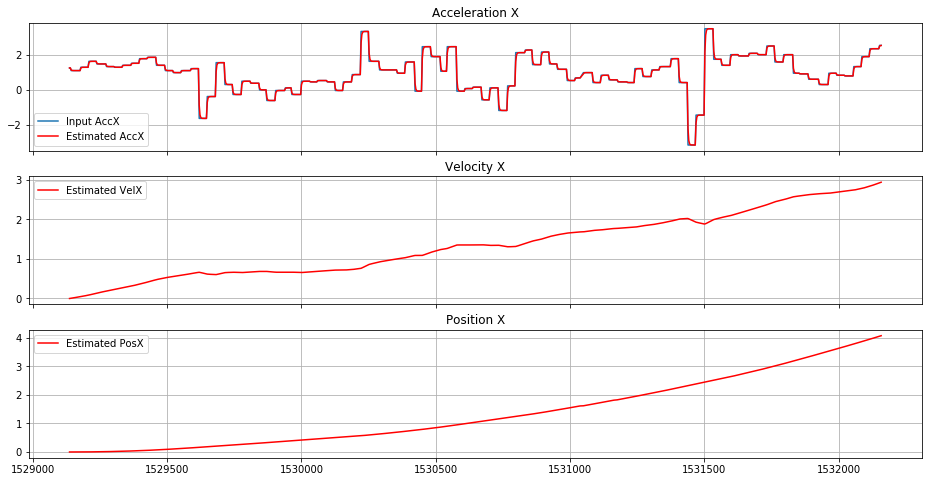

In [144]:
from pykalman import KalmanFilter

trial = 3
# Data description
Time = data[(data.trial == trial)].timestamp
#  AccX_HP - high precision acceleration signal
#  AccX_LP - low precision acceleration signal
#  RefPosX - real position (ground truth)
#  RefVelX - real velocity (ground truth)

AccX_Value = np.array([data[(data.trial == trial)].acc_z,]).T
AccX_Variance = 0.0005

# time step
dt = 0.003

# transition_matrix  
F = [[1, dt, 0.5*dt**2], 
     [0,  1,       dt],
     [0,  0,        1]]

# observation_matrix   
H = [0, 0, 1]

# transition_covariance 
Q = [[0.2,    0,      0], 
     [  0,  0.1,      0],
     [  0,    0,  10e-4]]

# observation_covariance 
R = AccX_Variance

# initial_state_mean
X0 = [0,
      0,
      AccX_Value[0, 0]]

# initial_state_covariance
P0 = [[  0,    0,               0], 
      [  0,    0,               0],
      [  0,    0,   AccX_Variance]]

n_timesteps = AccX_Value.shape[0]
n_dim_state = 3
filtered_state_means = np.zeros((n_timesteps, n_dim_state))
filtered_state_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))

kf = KalmanFilter(transition_matrices = F, 
                  observation_matrices = H, 
                  transition_covariance = Q, 
                  observation_covariance = R, 
                  initial_state_mean = X0, 
                  initial_state_covariance = P0)

# iterative estimation for each new measurement
for t in range(n_timesteps):
    if t == 0:
        filtered_state_means[t] = X0
        filtered_state_covariances[t] = P0
    else:
        filtered_state_means[t], filtered_state_covariances[t] = (
        kf.filter_update(
            filtered_state_means[t-1],
            filtered_state_covariances[t-1],
            AccX_Value[t, 0]
        )
    )


f, axarr = plt.subplots(3, sharex=True, figsize=(16,8))

axarr[0].plot(Time, AccX_Value, label="Input AccX")
axarr[0].plot(Time, filtered_state_means[:, 2], "r-", label="Estimated AccX")
axarr[0].set_title('Acceleration X')
axarr[0].grid()
axarr[0].legend()
#axarr[0].set_ylim([-20, 20])

#axarr[1].plot(Time, RefVelX, label="Reference VelX")
axarr[1].plot(Time, filtered_state_means[:, 1], "r-", label="Estimated VelX")
axarr[1].set_title('Velocity X')
axarr[1].grid()
axarr[1].legend()
#axarr[1].set_ylim([0, 15])

#axarr[2].plot(Time, RefPosX, label="Reference PosX")
axarr[2].plot(Time, filtered_state_means[:, 0], "r-", label="Estimated PosX")
axarr[2].set_title('Position X')
axarr[2].grid()
axarr[2].legend()
#axarr[2].set_ylim([0, 20])

plt.show()